# (E10)10th_Project-Human_Segmentation
*******************************************************************************

## 1. 인물 사진 아웃포커싱
## 2. 인물 사진 배경전환 크로마키
## 3. 고양이 사진 아웃포커싱
## 4. 인물 사진에서 발생한 문제와 해결방법



********************************************************************************

## 1. 인물 사진 아웃포커싱

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

(4032, 3024, 3)


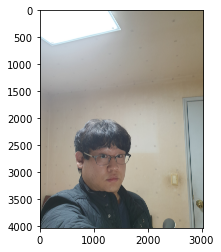

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/20210113_022222.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

      본인 사진을 불러와줍니다. 전에 사용했던 사진을 재활용했습니다.
      크기를 확인해 본 결과 3024X4032입니다. 나중에 배경크로마키에 활용하기 위해 기억해 둡시다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map


In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj39/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(4032, 3024, 3) (513, 384, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

      딥러닝을 통해 각각의 물체에 붙은 라벨들입니다. 우리가 사용할 인간과 고양이는 각각 15와 8입니다.

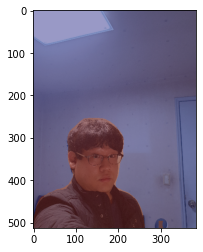

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

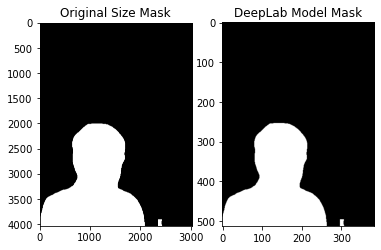

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

      잘린 부분을 보니 대부분 다 잘렸지만 밑에 살짝 나온 의자의 전체도 아닌 일부가 같이 사람으로 판정받은 걸 확인했습니다.

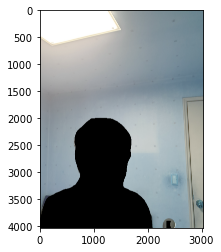

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

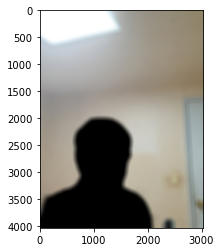

In [10]:
img_bg_blur = cv2.blur(img_bg, (100,100))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

      배경을 블러 처리 해줍니다. 낮으니까 티가 잘 안나서 더 진하게 블러 처리를 해주었습니다.

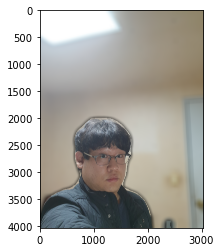

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

      블러 효과가 적용된 배경에 인물 사진만 합성하여 결과물을 출력해주었습니다.

## 2. 인물 사진 배경전환 크로마키

(1080, 1444, 3)


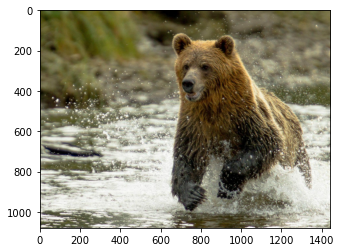

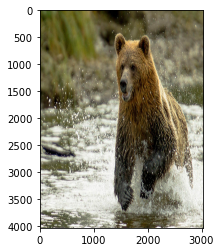

In [12]:
sys_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bear2.jpg'
sys_orig = cv2.imread(sys_path) 
print (sys_orig.shape)

plt.imshow(cv2.cvtColor(sys_orig, cv2.COLOR_BGR2RGB))
plt.show()

sys_orig_resize = cv2.resize(sys_orig, dsize=(3024,4032),interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(sys_orig_resize, cv2.COLOR_BGR2RGB))
plt.show()

      배경으로 쓸 사진을 불러옵니다. 저는 대자연이 숨쉬는 경관을 가져왔습니다.

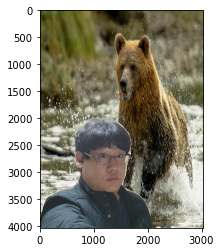

In [13]:
sys_concat = np.where(img_mask_color==255, img_orig, sys_orig_resize)
plt.imshow(cv2.cvtColor(sys_concat, cv2.COLOR_BGR2RGB))
plt.show()

      위에서 진행했던 효과를 입힌 배경을 합성한 단계와 동일하게 진행해줍니다. 이 경우 효과과 적용된 배경 이미지 대신 새로 불러온 배경 이미지에 인물 사진을 합성해줍니다.

## 3. 고양이 사진 아웃포커싱

      이번에는 고양이 사진을 이용하여 고양이를 잘 인식하는지 확인해봤습니다. 고양이 사진으로는 스트리머'자동'의 '호야' 사진을 사용하였습니다. 전체적인 과정은 인물 사진과 똑같이 진행했습니다.

(272, 480, 3)


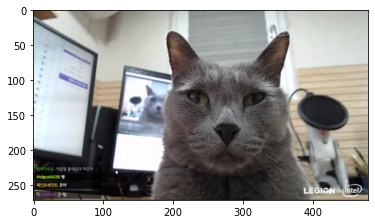

In [14]:
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_orig = cv2.imread(cat_path) 
print (cat_orig.shape)

plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
cat_resized, seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, seg_map.max())

(272, 480, 3) (290, 513, 3) 20


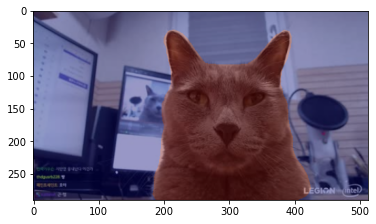

In [16]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

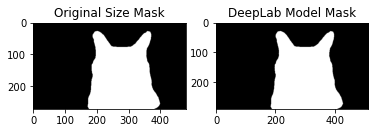

In [17]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

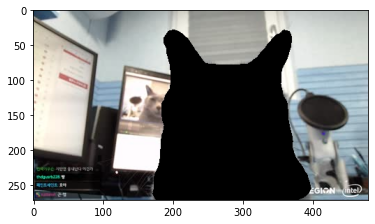

In [18]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg = cv2.bitwise_and(cat_orig, cat_bg_mask)
plt.imshow(cat_bg)
plt.show()

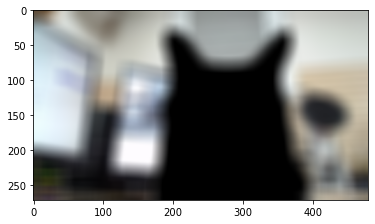

In [19]:
cat_bg_blur = cv2.blur(cat_bg, (25,25))
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

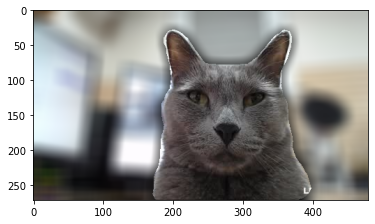

In [20]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

      고양이 감상에 방해가 되던 배경은 잘 안보이고 오직 고양이에게 집중 할 수 있는 이미지가 완성되었습니다.

## 4. 인물 사진에서 발생한 문제와 해결방법



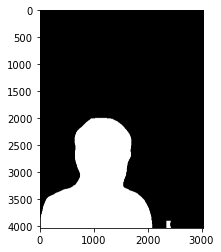

In [21]:
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
plt.show()

      인물 사진을 확인해 본 결과 밑에 사람이 아닌 부분도 사람으로 판정한 걸 확인할 수 있었다.
      사람 근처에 있거나 붙어있거나 유사한 색을 띄고 있으면 사람으로 판별하는 것 같다.
      
      이러한 문제를 해결하기 위해 대부분 같은 방향을 두 개 이상의 카메라로 촬영하는 방법이나 LiDAR depth sensor를 사용한다. 그러나 비용적 한계나 항상 적용 가능한 방법이 아니다. 노드에서 제시한 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에서는 딥러닝을 통해 하나의 사진으로도 피사계심도를 아주 정확하고 빠르게 판별 할 수 있다고 제시하고 있다.

******************************************************************************
# 총평 및 결론

      전체적으로 노드에서 소개된 과정만 따라하면 끝낼 수 있는 익스플로레이션이였다. 특히 요즘 많이 쓰이는 합성이나 사람의 외곽선을 따는 방법을 딥러닝을 통해 수작업이 아니라 빠르게 진행 할 수 있음을 배울 수 있었다.
      아직 더 해결해야할 문제점이 있고 해결책도 제시해주었다. 
    
      1. 카메라를 2개 이상을 쓰거나
      2. LiDAR depth 센서를 사용하거나
      
      이러한 방법은 하드웨어적 해결책이고 소프트웨어적으로도 해결할 수 있음을 배웠다.